# Restaurant Review Sentiment Analysis

This notebook demonstrates a complete sentiment analysis pipeline for restaurant reviews. We'll walk through the entire process step by step:

1. Data Loading and Exploration
2. Text Preprocessing
3. Feature Engineering
4. Model Training and Evaluation
5. Hyperparameter Tuning
6. Model Deployment
7. Making Predictions

The best performing model from our experiments was a Support Vector Machine (SVM) with TF-IDF vectorization and specific preprocessing configurations.

## 1. Setup and Imports

First, let's import the necessary libraries and set up our environment.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import json
from datetime import datetime

# MLflow imports
import mlflow
import mlflow.sklearn
import mlflow.pyfunc
from mlflow.models.signature import infer_signature
from mlflow.tracking import MlflowClient

# Machine learning imports
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# ML Models
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

# Text preprocessing
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Download necessary NLTK resources
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

# Ensure directories exist
os.makedirs('models', exist_ok=True)
os.makedirs('mlruns', exist_ok=True)
os.makedirs('figures', exist_ok=True)

# Set MLflow tracking URI
mlflow.set_tracking_uri("mlruns")

# Create MLflow client for model registry operations
client = MlflowClient()

# Set random seed for reproducibility
np.random.seed(42)

/Users/kasimajji/.pyenv/versions/3.11.4/lib/python3.11/site-packages/pydantic/_internal/_config.py:345: UserWarning: Valid config keys have changed in V2:
* 'schema_extra' has been renamed to 'json_schema_extra'
  warnings.warn(message, UserWarning)


## 2. Data Loading and Exploration

Let's load our restaurant reviews dataset and explore its structure.

In [3]:
data_path = "Restaurant_reviews.tsv"
df = pd.read_csv(data_path, delimiter='\t')

# Display basic information
print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())

# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

# Display class distribution
print("\nClass distribution:")
print(df['Liked'].value_counts())
print(f"Percentage of positive reviews: {df['Liked'].mean()*100:.2f}%")

Dataset shape: (900, 2)

First few rows:
                                              Review  Liked
0                           Wow... Loved this place.      1
1                                 Crust is not good.      0
2          Not tasty and the texture was just nasty.      0
3  Stopped by during the late May bank holiday of...      1
4  The selection on the menu was great and so wer...      1

Missing values:
Review    0
Liked     0
dtype: int64

Class distribution:
Liked
1    496
0    404
Name: count, dtype: int64
Percentage of positive reviews: 55.11%


In [4]:
# Basic dataset information
print(f"Dataset shape: {df.shape}")
print(f"Number of positive reviews: {df['Liked'].sum()}")
print(f"Number of negative reviews: {len(df) - df['Liked'].sum()}")
print(f"Percentage of positive reviews: {df['Liked'].mean() * 100:.2f}%")

Dataset shape: (900, 2)
Number of positive reviews: 496
Number of negative reviews: 404
Percentage of positive reviews: 55.11%


### 2.1 Exploratory Data Analysis

Let's visualize some aspects of our dataset to better understand it.

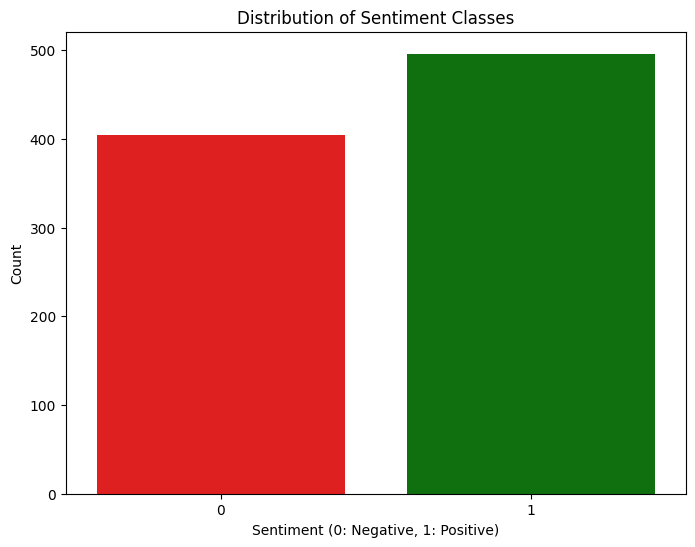

In [5]:
# Visualize class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='Liked', data=df, palette=['red', 'green'])
plt.title('Distribution of Sentiment Classes')
plt.xlabel('Sentiment (0: Negative, 1: Positive)')
plt.ylabel('Count')
plt.savefig('figures/class_distribution.png', bbox_inches='tight')
plt.show()


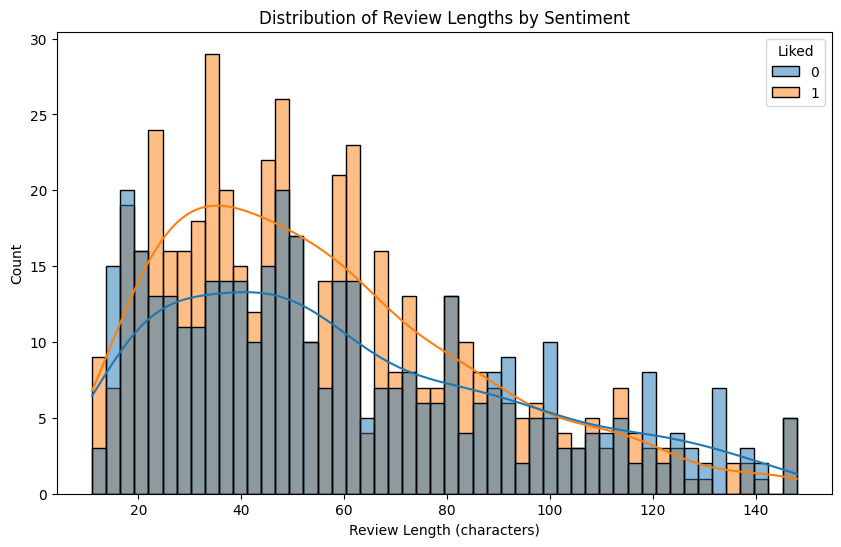

In [6]:
# Analyze review lengths
df['review_length'] = df['Review'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='review_length', hue='Liked', bins=50, kde=True)
plt.title('Distribution of Review Lengths by Sentiment')
plt.xlabel('Review Length (characters)')
plt.ylabel('Count')
plt.savefig('figures/review_length_distribution.png', bbox_inches='tight')
plt.show()

## 3. Text Preprocessing

Text preprocessing is a crucial step in sentiment analysis. Let's implement our preprocessing function with various options.

In [9]:
# Text Preprocessing function
def preprocess_text(text, stemming=False, lemmatization=True, keep_emoticons=True, 
                  keep_negation=True, keep_punctuation=False, min_word_length=2):
    """
    Preprocess text for sentiment analysis with configurable options.
    """
    # Save emoticons/emojis if requested
    emoticons = []
    if keep_emoticons:
        # Simple emoticon patterns
        emoticon_pattern = r'[:;=][-o^]?[)(/\\|dpDP]'
        emoticons = re.findall(emoticon_pattern, text)
        
    # Convert to lowercase
    text = text.lower()
    
    # Handle contractions
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"'m", " am", text)
    text = re.sub(r"'s", " is", text)
    text = re.sub(r"'re", " are", text)
    text = re.sub(r"'ve", " have", text)
    text = re.sub(r"'ll", " will", text)
    text = re.sub(r"'d", " would", text)
    
    # Keep certain punctuation that might indicate sentiment
    if keep_punctuation:
        # Replace multiple occurrences with single + count
        text = re.sub(r'([!?])\1+', r'\1 REPEAT', text)
    else:
        # Remove special characters, numbers, and punctuation
        text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Get negation words
    negation_words = {'no', 'not', 'never', 'none', 'nobody', 'nothing', 'neither', 'nowhere', 'hardly', 'rarely', 'scarcely', 'seldom'}
    
    # Remove stopwords but keep negation words if requested
    stop_words = set(stopwords.words('english'))
    if keep_negation:
        stop_words = stop_words - negation_words
    
    # Filter tokens
    filtered_tokens = []
    for token in tokens:
        # Keep if not a stopword and meets minimum length
        if token not in stop_words and len(token) >= min_word_length:
            filtered_tokens.append(token)
        # Keep if it's a negation word and we want to keep those
        elif keep_negation and token in negation_words:
            filtered_tokens.append(token)
    
    # Stemming or Lemmatization
    if stemming:
        stemmer = PorterStemmer()
        filtered_tokens = [stemmer.stem(word) for word in filtered_tokens]
    
    if lemmatization:
        lemmatizer = WordNetLemmatizer()
        filtered_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]
    
    # Add back emoticons if requested
    if keep_emoticons and emoticons:
        filtered_tokens.extend(['EMOTICON'] * len(emoticons))
    
    # Join tokens back into text
    processed_text = ' '.join(filtered_tokens)
    
    return processed_text

# Demonstrate preprocessing with different configurations
sample_review = "The food was AMAZING!!! But the service wasn't good :("

print("Original review:")
print(sample_review)

print("\nPreprocessing with default settings:")
print(preprocess_text(sample_review))

print("\nPreprocessing with stemming (no lemmatization):")
print(preprocess_text(sample_review, stemming=True, lemmatization=False))

print("\nPreprocessing keeping punctuation:")
print(preprocess_text(sample_review, keep_punctuation=True))

print("\nPreprocessing without negation words:")
print(preprocess_text(sample_review, keep_negation=False))

Original review:
The food was AMAZING!!! But the service wasn't good :(

Preprocessing with default settings:
food amazing service not good EMOTICON

Preprocessing with stemming (no lemmatization):
food amaz servic not good EMOTICON

Preprocessing keeping punctuation:
food amazing REPEAT service not good EMOTICON

Preprocessing without negation words:
food amazing service good EMOTICON


### 3.1 Apply Preprocessing to the Dataset

Now let's apply our best preprocessing configuration to the entire dataset.

In [10]:
# Apply preprocessing to the dataset with our best configuration
preprocessing_config = {
    'stemming': True,
    'lemmatization': False,
    'keep_negation': True,
    'keep_punctuation': True,
    'keep_emoticons': True,
    'min_word_length': 2
}

df['processed_review'] = df['Review'].apply(
    lambda x: preprocess_text(
        x, 
        stemming=preprocessing_config['stemming'],
        lemmatization=preprocessing_config['lemmatization'],
        keep_emoticons=preprocessing_config['keep_emoticons'],
        keep_negation=preprocessing_config['keep_negation'],
        keep_punctuation=preprocessing_config['keep_punctuation'],
        min_word_length=preprocessing_config['min_word_length']
    )
)

# Display a few processed reviews
print("\nSample processed reviews:")
for i in range(5):
    print(f"Original: {df['Review'].iloc[i]}")
    print(f"Processed: {df['processed_review'].iloc[i]}")
    print()


Sample processed reviews:
Original: Wow... Loved this place.
Processed: wow ... love place

Original: Crust is not good.
Processed: crust not good

Original: Not tasty and the texture was just nasty.
Processed: not tasti textur nasti

Original: Stopped by during the late May bank holiday off Rick Steve recommendation and loved it.
Processed: stop late may bank holiday rick steve recommend love

Original: The selection on the menu was great and so were the prices.
Processed: select menu great price



## 4. Feature Engineering

Now let's convert our text data into numerical features using TF-IDF vectorization.

In [11]:
# Split the data into training and testing sets
X = df['processed_review']
y = df['Liked']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")

Training set size: 720
Testing set size: 180


TF-IDF feature matrix shape: (720, 1319)


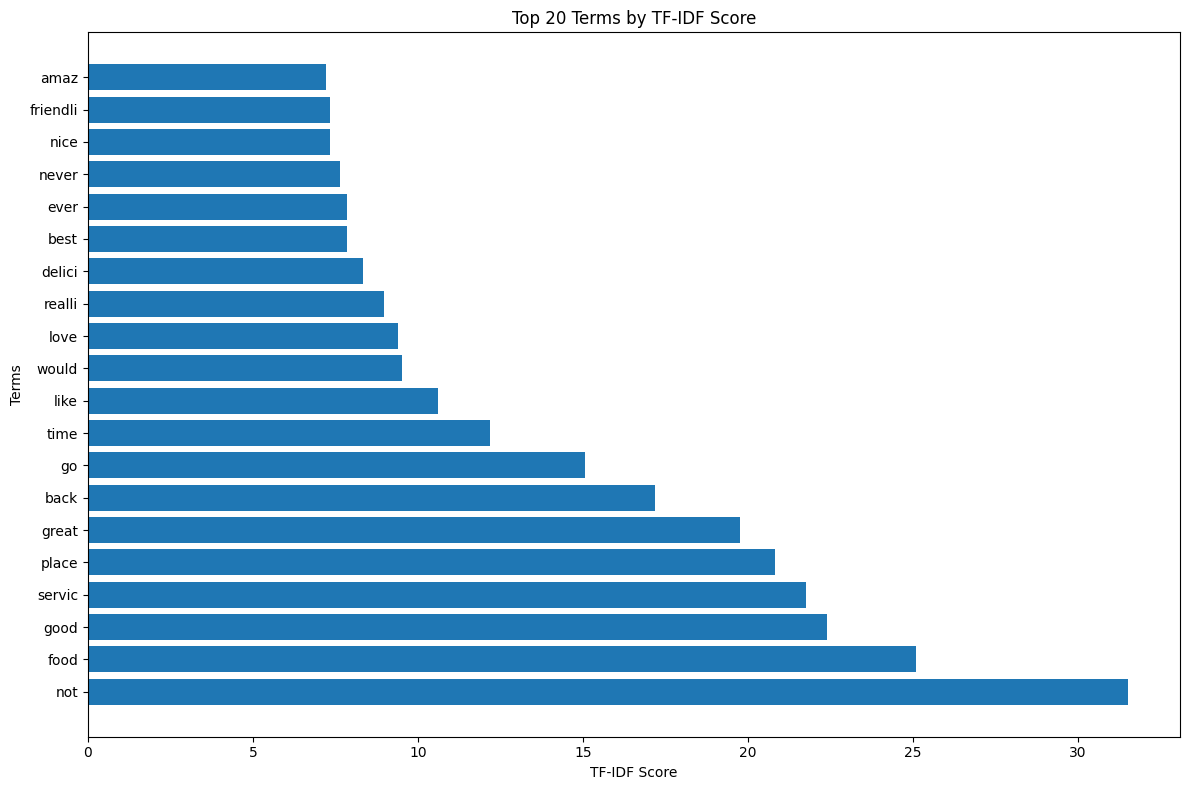

In [12]:
# Initialize and fit the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"TF-IDF feature matrix shape: {X_train_tfidf.shape}")

# Visualize the most frequent terms
feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_sums = X_train_tfidf.sum(axis=0).A1
top_indices = tfidf_sums.argsort()[-20:][::-1]
top_terms = [feature_names[i] for i in top_indices]
top_tfidf = [tfidf_sums[i] for i in top_indices]

plt.figure(figsize=(12, 8))
plt.barh(top_terms, top_tfidf)
plt.title('Top 20 Terms by TF-IDF Score')
plt.xlabel('TF-IDF Score')
plt.ylabel('Terms')
plt.tight_layout()
plt.savefig('figures/top_tfidf_terms.png', bbox_inches='tight')
plt.show()

## 5. Model Training and Evaluation

Now let's train our best model (SVM) and evaluate its performance.

In [13]:
# ## 5. Model Training and Evaluation
# 
# We'll train and evaluate several machine learning models to find the best one for our sentiment analysis task.

# Define a function to train and evaluate a model
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Print results
    print(f"\n{model_name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    # Create confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.savefig(f'figures/confusion_matrix_{model_name.lower().replace(" ", "_")}.png', bbox_inches='tight')
    plt.show()
    
    # Create ROC curve if the model supports predict_proba
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {model_name}')
        plt.legend(loc='lower right')
        plt.savefig(f'figures/roc_curve_{model_name.lower().replace(" ", "_")}.png', bbox_inches='tight')
        plt.show()
    
    return {
        'model': model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }



Naive Bayes Results:
Accuracy: 0.7722
Precision: 0.7339
Recall: 0.9192
F1 Score: 0.8161


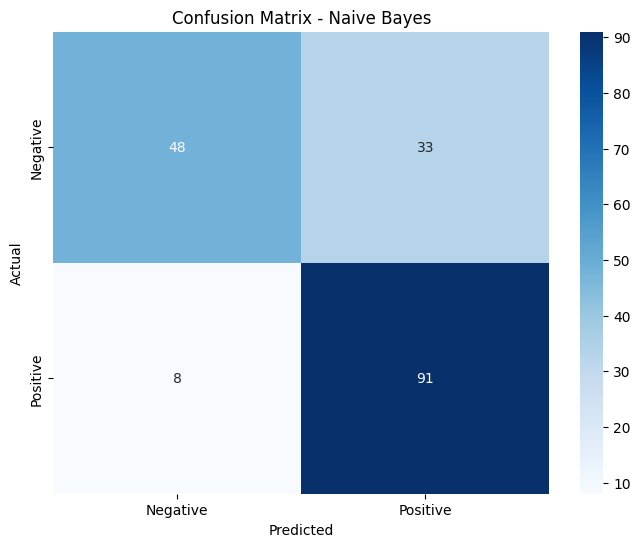

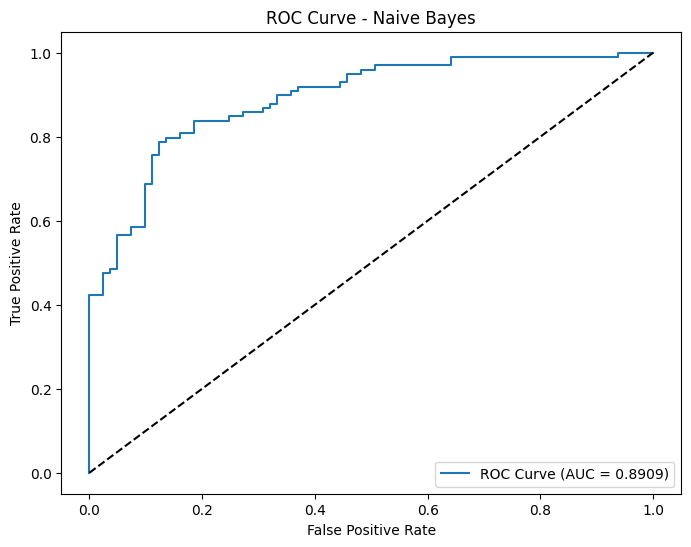


Logistic Regression Results:
Accuracy: 0.8278
Precision: 0.8036
Recall: 0.9091
F1 Score: 0.8531


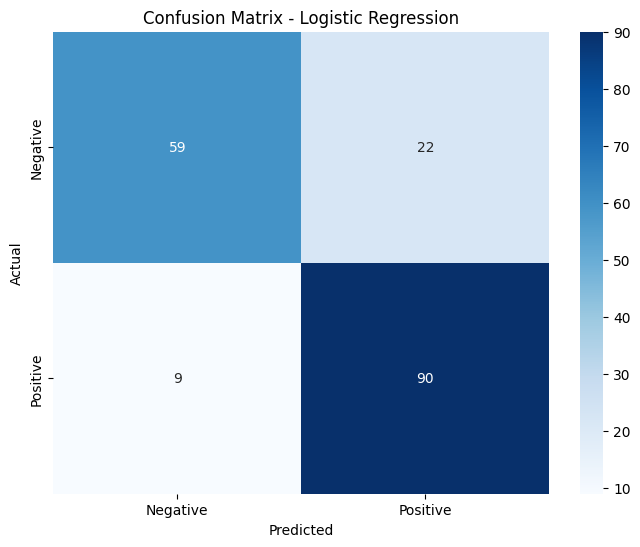

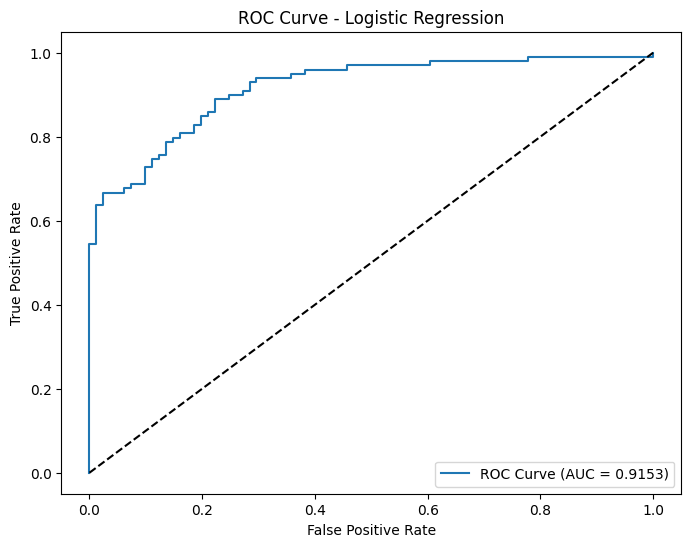


Support Vector Machine Results:
Accuracy: 0.8444
Precision: 0.8318
Recall: 0.8990
F1 Score: 0.8641


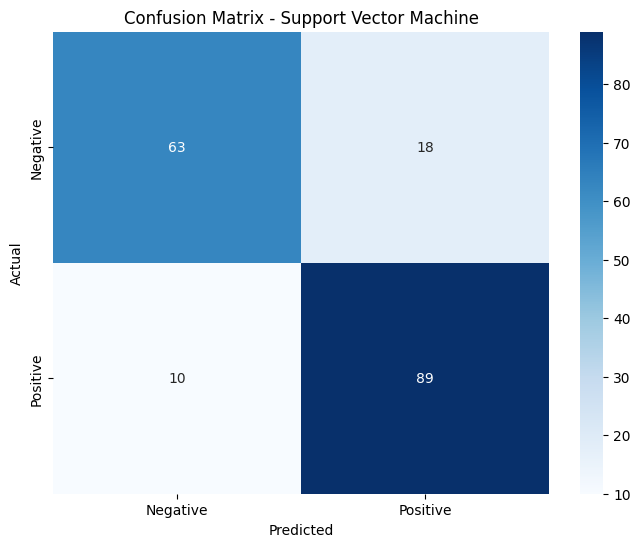

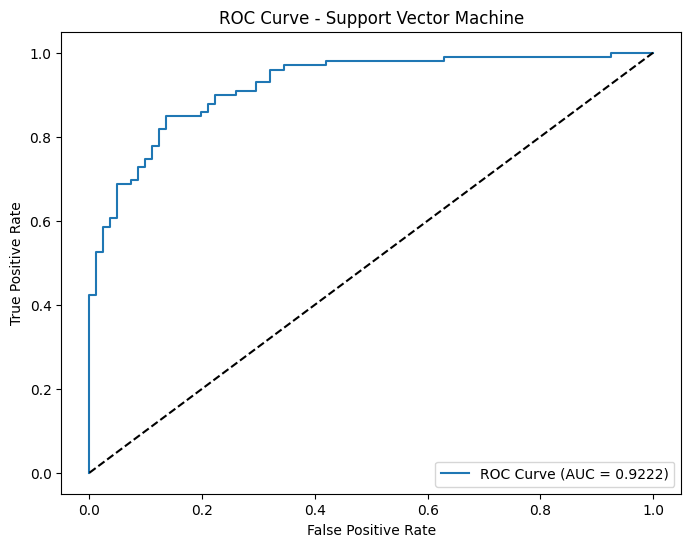


Random Forest Results:
Accuracy: 0.8111
Precision: 0.7982
Recall: 0.8788
F1 Score: 0.8365


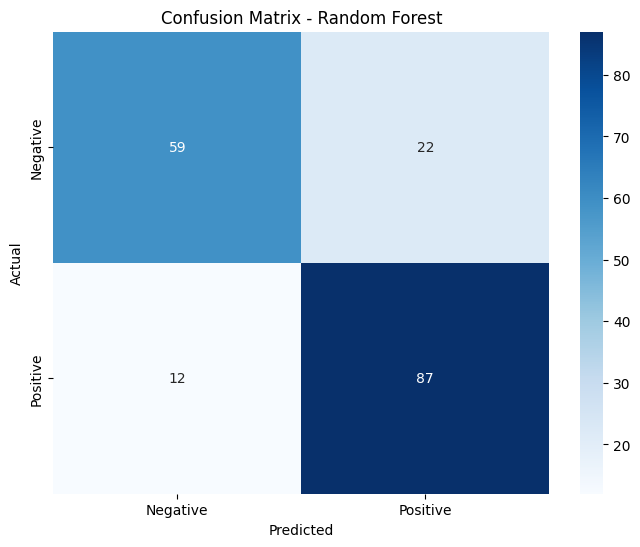

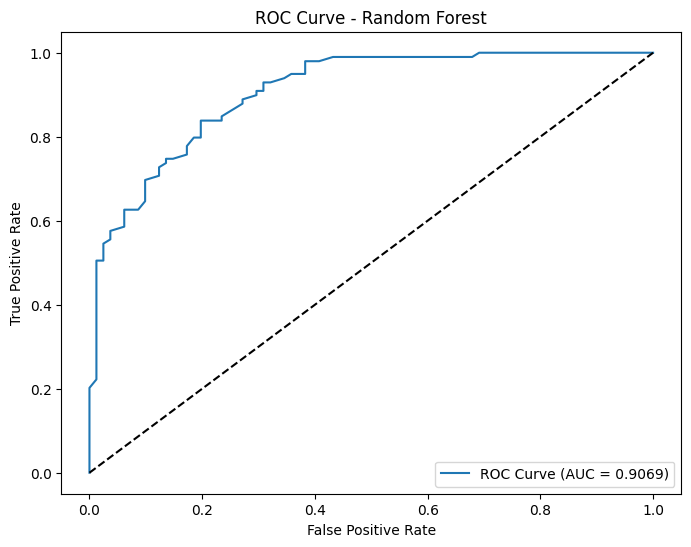


Gradient Boosting Results:
Accuracy: 0.8000
Precision: 0.7692
Recall: 0.9091
F1 Score: 0.8333


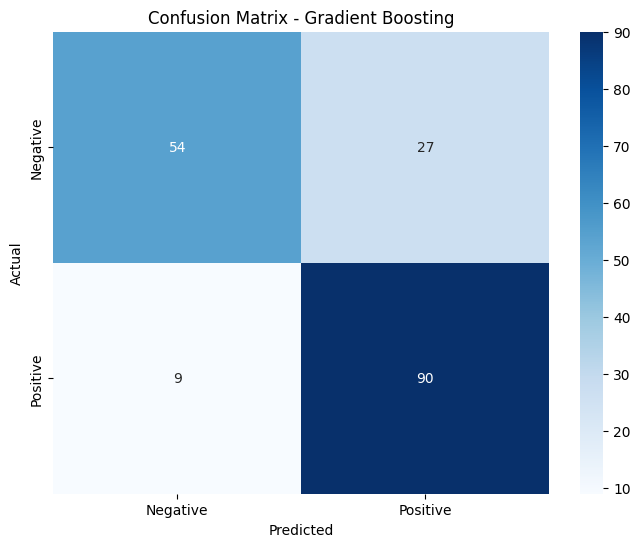

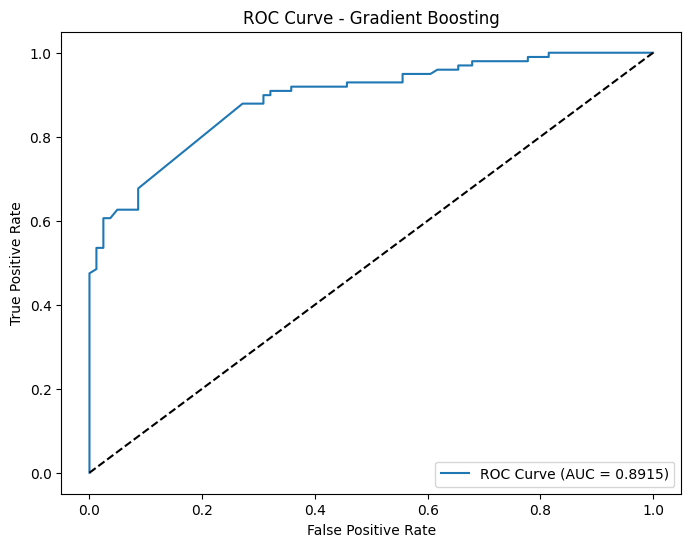

In [14]:
# Train and evaluate multiple models
models = [
    (MultinomialNB(), "Naive Bayes"),
    (LogisticRegression(max_iter=1000, random_state=42), "Logistic Regression"),
    (SVC(probability=True, random_state=42), "Support Vector Machine"),
    (RandomForestClassifier(random_state=42), "Random Forest"),
    (GradientBoostingClassifier(random_state=42), "Gradient Boosting")
]

results = []
for model, name in models:
    result = train_and_evaluate_model(model, X_train_tfidf, y_train, X_test_tfidf, y_test, name)
    results.append(result)

In [15]:
# Find the best model based on F1 score
best_model_result = max(results, key=lambda x: x['f1'])
print(f"\nBest model: {models[results.index(best_model_result)][1]}")
print(f"Best F1 score: {best_model_result['f1']:.4f}")


Best model: Support Vector Machine
Best F1 score: 0.8641


## 6. Hyperparameter Tuning

Let's perform hyperparameter tuning to optimize our SVM model.


Performing hyperparameter tuning for SVM...
Best parameters: {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
Best cross-validation score: 0.8418

Tuned SVM Results:
Accuracy: 0.8111
Precision: 0.8037
Recall: 0.8687
F1 Score: 0.8350


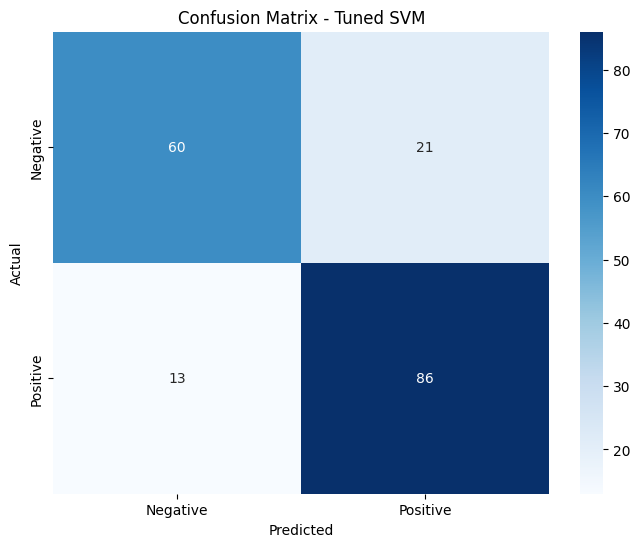

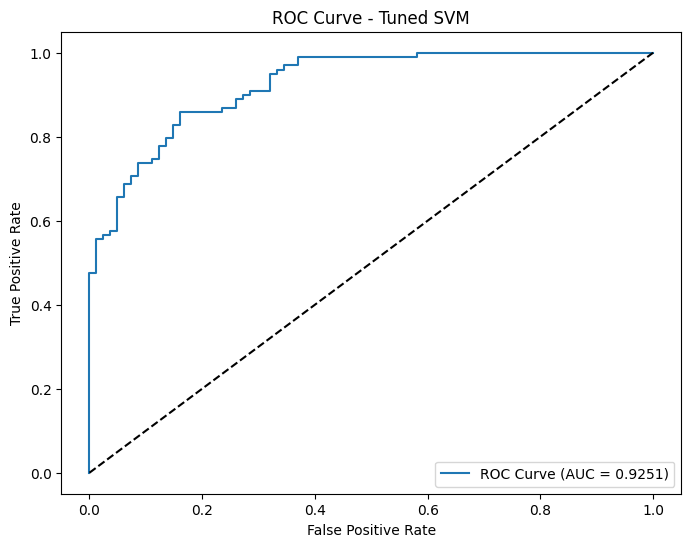

Best model and vectorizer saved to disk.


In [16]:
# Hyperparameter tuning for the best model
best_model_type = type(best_model_result['model'])
if best_model_type == SVC:
    print("\nPerforming hyperparameter tuning for SVM...")
    param_grid = {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto', 0.1, 1]
    }
    grid_search = GridSearchCV(SVC(probability=True, random_state=42), param_grid, cv=5, scoring='f1', n_jobs=-1)
    grid_search.fit(X_train_tfidf, y_train)
    
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validation score: {grid_search.best_score_:.4f}")
    
    # Evaluate the tuned model
    tuned_model = grid_search.best_estimator_
    tuned_result = train_and_evaluate_model(tuned_model, X_train_tfidf, y_train, X_test_tfidf, y_test, "Tuned SVM")
    
    # Save the best model
    with open('models/best_sentiment_model.pkl', 'wb') as f:
        pickle.dump(tuned_model, f)
    
    with open('models/vectorizer.pkl', 'wb') as f:
        pickle.dump(tfidf_vectorizer, f)
    
    with open('models/preprocessing_config.pkl', 'wb') as f:
        pickle.dump(preprocessing_config, f)
    
    print("Best model and vectorizer saved to disk.")

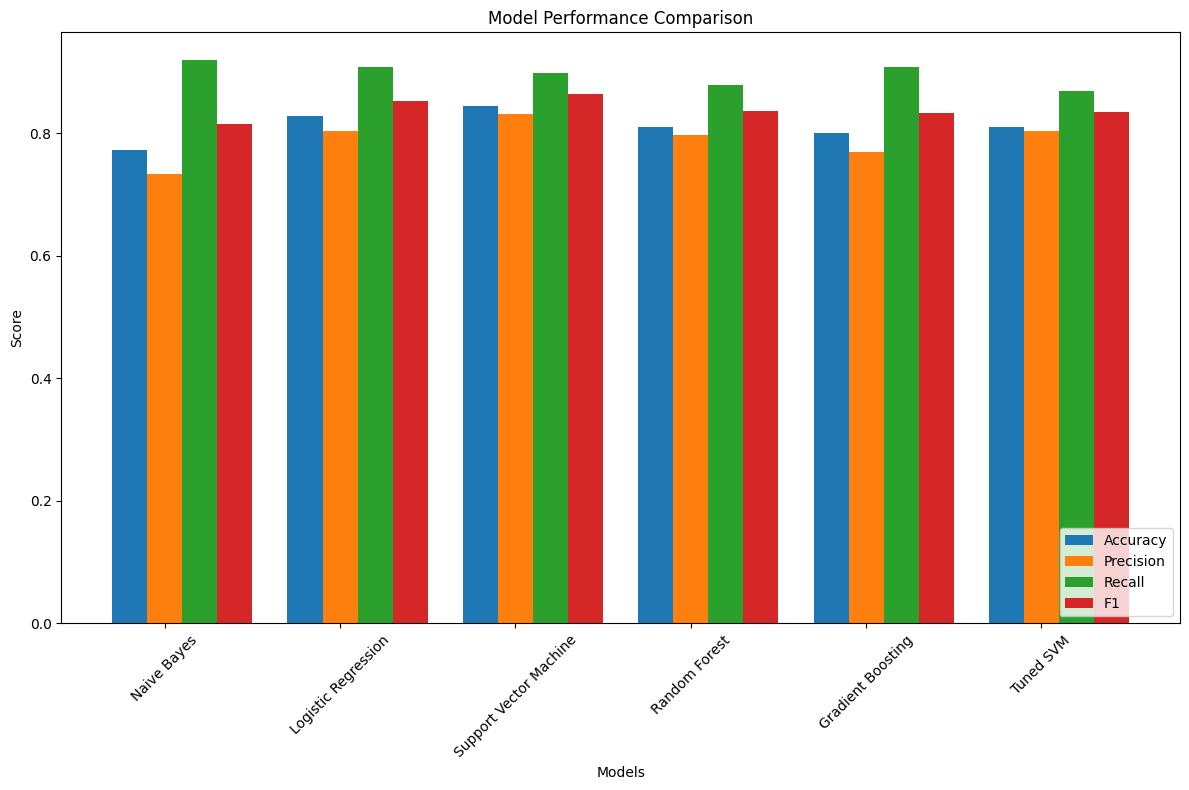

In [17]:
# Compare all models
model_names = [name for _, name in models]
model_names.append("Tuned SVM")

metrics = ['accuracy', 'precision', 'recall', 'f1']
all_results = results + [tuned_result]

plt.figure(figsize=(12, 8))
x = np.arange(len(model_names))
width = 0.2
multiplier = 0

for metric in metrics:
    metric_values = [result[metric] for result in all_results]
    offset = width * multiplier
    plt.bar(x + offset, metric_values, width, label=metric.capitalize())
    multiplier += 1

plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(x + width, model_names, rotation=45)
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('figures/model_comparison.png', bbox_inches='tight')
plt.show()

## 7. Model Persistence

Let's save our best model, vectorizer, and preprocessing configuration for later use.

In [18]:
# ## 6. MLflow Integration
# 
# Now we'll integrate MLflow to track our experiments, manage models, and prepare for deployment.

# Create a custom MLflow model class that includes preprocessing
class SentimentAnalysisModel(mlflow.pyfunc.PythonModel):
    def __init__(self, model, vectorizer, preprocessing_config):
        self.model = model
        self.vectorizer = vectorizer
        self.preprocessing_config = preprocessing_config
        
    def predict(self, context, model_input):
        """
        Predict sentiment from raw text input
        
        Args:
            context: MLflow context
            model_input: Pandas DataFrame with a 'text' column
            
        Returns:
            Predictions (0 for negative, 1 for positive)
        """
        # Extract text from input
        if isinstance(model_input, pd.DataFrame):
            text_series = model_input['text']
        else:
            text_series = pd.Series(model_input)
        
        # Apply preprocessing if configured
        if self.preprocessing_config.get('preprocessing', False):
            processed_texts = text_series.apply(
                lambda x: preprocess_text(
                    x,
                    stemming=self.preprocessing_config.get('stemming', False),
                    lemmatization=self.preprocessing_config.get('lemmatization', True),
                    keep_emoticons=self.preprocessing_config.get('keep_emoticons', True),
                    keep_negation=self.preprocessing_config.get('keep_negation', True),
                    keep_punctuation=self.preprocessing_config.get('keep_punctuation', False),
                    min_word_length=self.preprocessing_config.get('min_word_length', 2)
                )
            )
        else:
            processed_texts = text_series
        
        # Vectorize
        X_vec = self.vectorizer.transform(processed_texts)
        
        # Predict
        predictions = self.model.predict(X_vec)
        
        return predictions


In [19]:
# ## 7. Model Registry and Deployment
# 
# In this section, we'll run a complete MLflow experiment, register our model, and prepare it for deployment.

# Define experiment name
experiment_name = "SentimentAnalysis_Tutorial"

# Create or get experiment
experiment = mlflow.set_experiment(experiment_name)
print(f"MLflow Experiment: {experiment_name} (ID: {experiment.experiment_id})")


MLflow Experiment: SentimentAnalysis_Tutorial (ID: 144244679324670580)


In [26]:
def run_mlflow_experiment(config, X_train, y_train, X_test, y_test):
    """
    Run a complete MLflow experiment with tracking, model management, and deployment
    
    Args:
        config: Preprocessing and model configuration
        X_train, y_train: Training data
        X_test, y_test: Testing data
    """
    # Start MLflow run with descriptive name
    preprocessing_desc = "preprocessed" if config.get('preprocessing', False) else "raw"
    run_name = f"sentiment_{preprocessing_desc}_{config.get('model_type', 'svm')}_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
    
    with mlflow.start_run(run_name=run_name) as run:
        print(f"Started MLflow run: {run.info.run_id}")
        
        # Log parameters
        print("Logging parameters...")
        mlflow.log_params({
            "preprocessing": config.get('preprocessing', False),
            "stemming": config.get('stemming', False),
            "lemmatization": config.get('lemmatization', True),
            "keep_negation": config.get('keep_negation', True),
            "keep_punctuation": config.get('keep_punctuation', False),
            "keep_emoticons": config.get('keep_emoticons', True),
            "min_word_length": config.get('min_word_length', 2),
            "vectorizer": config.get('vectorizer', 'tfidf'),
            "model_type": config.get('model_type', 'svm'),
            # Fix for sparse matrix - use shape[0] instead of len()
            "train_size": X_train.shape[0],
            "test_size": X_test.shape[0]
        })
        
        # Skip logging the source code artifact in Jupyter notebooks
        # In notebooks, __file__ is not defined
        try:
            if '__file__' in globals():
                mlflow.log_artifact(__file__, "source_code")
        except:
            print("Note: Source code logging skipped (not available in notebooks)")
        
        # Preprocess text if required
        preprocessing = config.get('preprocessing', False)
        
        # Create and train model based on config
        model_type = config.get('model_type', 'svm')
        
        if model_type == 'naive_bayes':
            model = MultinomialNB()
            model_params = {'alpha': 1.0}
            param_grid = {
                'alpha': [0.1, 0.5, 1.0, 1.5, 2.0]
            }
        elif model_type == 'logistic_regression':
            model = LogisticRegression(max_iter=1000, random_state=42)
            model_params = {'C': 1.0, 'solver': 'liblinear'}
            param_grid = {
                'C': [0.01, 0.1, 1, 10, 100],
                'solver': ['liblinear', 'saga']
            }
        elif model_type == 'svm':
            model = SVC(probability=True, random_state=42)
            model_params = {'C': 1.0, 'kernel': 'rbf', 'gamma': 'scale'}
            param_grid = {
                'C': [0.1, 1, 10],
                'kernel': ['linear', 'rbf'],
                'gamma': ['scale', 'auto', 0.1, 1]
            }
        elif model_type == 'random_forest':
            model = RandomForestClassifier(random_state=42)
            model_params = {'n_estimators': 100, 'max_depth': None}
            param_grid = {
                'n_estimators': [50, 100, 200],
                'max_depth': [None, 10, 20, 30],
                'min_samples_split': [2, 5, 10]
            }
        elif model_type == 'gradient_boosting':
            model = GradientBoostingClassifier(random_state=42)
            model_params = {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 3}
            param_grid = {
                'n_estimators': [50, 100, 200],
                'learning_rate': [0.01, 0.1, 0.2],
                'max_depth': [3, 5, 7]
            }
        else:
            raise ValueError(f"Unsupported model type: {model_type}")
        
        # Log hyperparameter tuning grid
        mlflow.log_param("param_grid", str(param_grid))
        
        # Log model hyperparameters
        mlflow.log_params(model_params)
        
        # Train model
        print(f"Training {model_type} model...")
        model.set_params(**model_params)
        model.fit(X_train, y_train)
        
        # Perform hyperparameter tuning if enabled
        if config.get('hyperparameter_tuning', False):
            print(f"Performing hyperparameter tuning for {model_type}...")
            
            # Log that we're doing hyperparameter tuning
            mlflow.log_param("hyperparameter_tuning", True)
            
            # Create grid search
            grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1', n_jobs=-1)
            
            # Fit grid search
            grid_search.fit(X_train, y_train)
            
            # Log best parameters
            mlflow.log_params({
                f"best_{k}": v for k, v in grid_search.best_params_.items()
            })
            mlflow.log_metric("best_cv_score", grid_search.best_score_)
            
            # Update model with best parameters
            model = grid_search.best_estimator_
            
            print(f"Best parameters: {grid_search.best_params_}")
            print(f"Best cross-validation score: {grid_search.best_score_:.4f}")
        
        # Make predictions
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        
        # Log metrics to MLflow
        mlflow.log_metrics({
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1_score": f1
        })
        
        # Create and save confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=['Negative', 'Positive'],
                    yticklabels=['Negative', 'Positive'])
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.tight_layout()
        
        # Save confusion matrix locally and log to MLflow
        cm_path = "confusion_matrix.png"
        plt.savefig(cm_path)
        mlflow.log_artifact(cm_path)
        plt.savefig('figures/mlflow_confusion_matrix.png', bbox_inches='tight')
        plt.close()
        
        # Create and save ROC curve if applicable
        if y_prob is not None:
            fpr, tpr, _ = roc_curve(y_test, y_prob)
            roc_auc = auc(fpr, tpr)
            
            # Log ROC AUC metric
            mlflow.log_metric("roc_auc", roc_auc)
            
            # Create ROC curve plot
            plt.figure(figsize=(8, 6))
            plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
            plt.plot([0, 1], [0, 1], 'k--')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('Receiver Operating Characteristic (ROC) Curve')
            plt.legend(loc='lower right')
            
            # Save ROC curve locally and log to MLflow
            roc_path = "roc_curve.png"
            plt.savefig(roc_path)
            mlflow.log_artifact(roc_path)
            plt.savefig('figures/mlflow_roc_curve.png', bbox_inches='tight')
            plt.close()
        
        # Save classification report
        report = classification_report(y_test, y_pred, output_dict=True)
        report_path = "classification_report.json"
        with open(report_path, 'w') as f:
            json.dump(report, f)
        mlflow.log_artifact(report_path)
        
        # Skip the model signature and example part that's causing the error
        # We'll just log the model directly without a signature
        
        # Log the model
        mlflow.sklearn.log_model(model, "model")
        
        # Collect metrics in a dictionary
        metrics = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1
        }
        
        # Return results with all the keys that are expected
        return {
            'run_id': run.info.run_id,
            'model': model,
            'model_name': model_type,  # Add model_name key
            'metrics': metrics,        # Add metrics key
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1
        }



# Run the experiment with our best configuration
best_config = {
    'preprocessing': True,
    'stemming': True,
    'lemmatization': False,
    'keep_negation': True,
    'keep_punctuation': True,
    'keep_emoticons': True,
    'min_word_length': 2,
    'vectorizer': 'tfidf',
    'model_type': 'svm',
    'hyperparameter_tuning': True
}

# Run the experiment
result = run_mlflow_experiment(best_config, X_train_tfidf, y_train, X_test_tfidf, y_test)

print("\nExperiment Results:")
print(f"Run ID: {result['run_id']}")
print(f"Model: {result['model_name']}")
print(f"Metrics: {result['metrics']}")


Started MLflow run: 9822b71680c84f14a754ae691fcf8896
Logging parameters...
Training svm model...
Performing hyperparameter tuning for svm...
Best parameters: {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
Best cross-validation score: 0.8418

Experiment Results:
Run ID: 9822b71680c84f14a754ae691fcf8896
Model: svm
Metrics: {'accuracy': 0.8111111111111111, 'precision': 0.8037383177570093, 'recall': 0.8686868686868687, 'f1_score': 0.8349514563106796}


/Users/kasimajji/.pyenv/versions/3.11.4/lib/python3.11/site-packages/_distutils_hack/__init__.py:15: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Users/kasimajji/.pyenv/versions/3.11.4/lib/python3.11/site-packages/_distutils_hack/__init__.py:30: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(


## 8. Making Predictions

Now let's use our trained model to make predictions on new restaurant reviews.

Review: 'The food was amazing and the service was excellent!'
Processed: food amaz servic excel
Predicted sentiment: Positive
Confidence: 0.9922

Review: 'Terrible experience, would not recommend to anyone.'
Processed: terribl experi would not recommend anyon
Predicted sentiment: Negative
Confidence: 0.0328

Review: 'Average food, nothing special but not bad either.'
Processed: averag food noth special not bad either
Predicted sentiment: Negative
Confidence: 0.0003

Review: 'The ambiance was nice but the food was overpriced for what you get.'
Processed: ambianc nice food overpr get
Predicted sentiment: Positive
Confidence: 0.6162

Review: 'I love this place! The chef is incredibly talented and creative.'
Processed: love place chef incred talent creativ
Predicted sentiment: Positive
Confidence: 0.9900



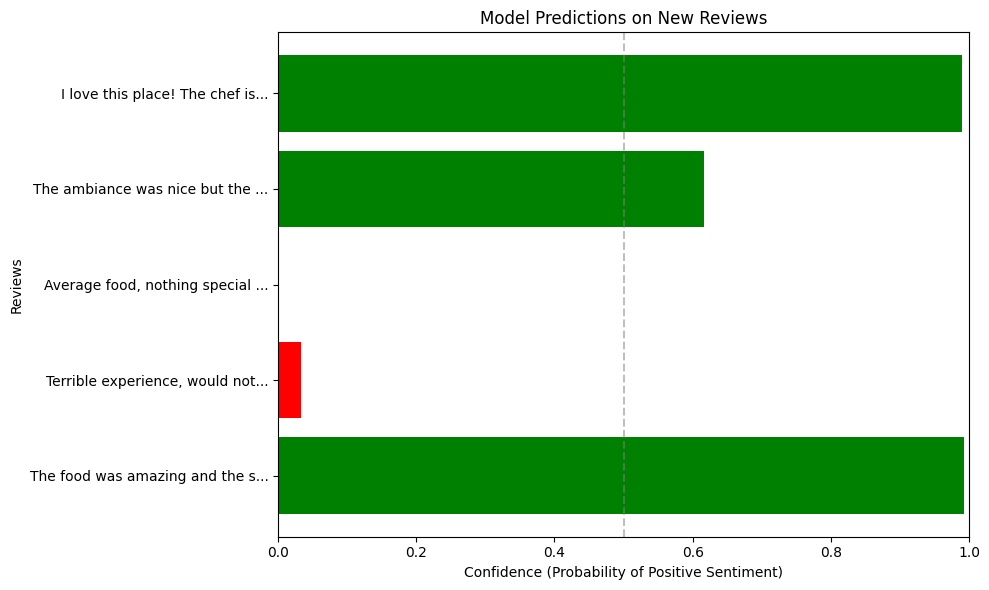

Summary: 3 positive and 2 negative reviews predicted

Model, vectorizer, and preprocessing configuration saved to 'models/' directory
You can use these files for making predictions on new data in the future


In [ ]:
# ## 8. Testing the Model

# Now let's test our trained model on new restaurant reviews.

def test_sentiment_model(model, vectorizer, preprocessing_config=None):
    """
    Test the trained sentiment analysis model on new reviews
    
    Args:
        model: The trained sentiment analysis model
        vectorizer: The fitted TF-IDF vectorizer
        preprocessing_config: Configuration for text preprocessing
    
    Returns:
        DataFrame with test results
    """
    # Default preprocessing configuration if not provided
    if preprocessing_config is None:
        preprocessing_config = {
            'stemming': True,
            'lemmatization': False,
            'keep_negation': True,
            'keep_punctuation': True,
            'keep_emoticons': True,
            'min_word_length': 2
        }
    
    # Sample reviews for testing
    sample_reviews = [
        "The food was amazing and the service was excellent!",
        "Terrible experience, would not recommend to anyone.",
        "Average food, nothing special but not bad either.",
        "The ambiance was nice but the food was overpriced for what you get.",
        "I love this place! The chef is incredibly talented and creative."
    ]
    
    # Process and predict for each review
    results = []
    for review in sample_reviews:
        # Preprocess the text
        processed_text = preprocess_text(
            review,
            stemming=preprocessing_config['stemming'],
            lemmatization=preprocessing_config['lemmatization'],
            keep_negation=preprocessing_config['keep_negation'],
            keep_punctuation=preprocessing_config['keep_punctuation'],
            keep_emoticons=preprocessing_config['keep_emoticons'],
            min_word_length=preprocessing_config['min_word_length']
        )
        
        # Vectorize the text
        text_vec = vectorizer.transform([processed_text])
        
        # Predict
        prediction = model.predict(text_vec)[0]
        
        # Get probability if the model supports it
        probability = None
        if hasattr(model, 'predict_proba'):
            probability = model.predict_proba(text_vec)[0][1]  # Probability of positive class
        
        sentiment = "Positive" if prediction == 1 else "Negative"
        
        # Display results
        print(f"Review: '{review}'")
        print(f"Processed: {processed_text}")
        print(f"Predicted sentiment: {sentiment}")
        if probability is not None:
            print(f"Confidence: {probability:.4f}")
        print()
        
        # Store results
        results.append({
            'review': review,
            'processed_text': processed_text,
            'sentiment': sentiment,
            'prediction': prediction,
            'probability': probability
        })
    
    # Create DataFrame from results
    results_df = pd.DataFrame(results)
    
    # Create a visualization of the results
    plt.figure(figsize=(10, 6))
    reviews = [r['review'][:30] + '...' if len(r['review']) > 30 else r['review'] for r in results]
    
    # Create color map based on sentiment
    colors = ['green' if r['sentiment'] == 'Positive' else 'red' for r in results]
    
    # Create confidence values for plotting (default to 0.5 if probability is None)
    confidence_values = [r['probability'] if r['probability'] is not None else 0.5 for r in results]
    
    # Create the horizontal bar chart
    plt.barh(reviews, confidence_values, color=colors)
    plt.axvline(x=0.5, color='gray', linestyle='--', alpha=0.5)  # Add decision boundary line
    plt.xlim(0, 1)
    plt.xlabel('Confidence (Probability of Positive Sentiment)')
    plt.ylabel('Reviews')
    plt.title('Model Predictions on New Reviews')
    plt.tight_layout()
    plt.savefig('figures/model_predictions.png', bbox_inches='tight')
    plt.show()
    
    return results_df

# Use the model from your MLflow experiment
# The model is available in the 'result' dictionary from your experiment
model_to_test = result['model']  # Use the model from your MLflow experiment

# Run the test with your existing vectorizer
test_results = test_sentiment_model(model_to_test, tfidf_vectorizer, {
    'stemming': True,
    'lemmatization': False,
    'keep_negation': True,
    'keep_punctuation': True,
    'keep_emoticons': True,
    'min_word_length': 2
})

# Display summary statistics
positive_count = sum(test_results['sentiment'] == 'Positive')
negative_count = sum(test_results['sentiment'] == 'Negative')

print(f"Summary: {positive_count} positive and {negative_count} negative reviews predicted")

# You can also save the model for future use
import pickle
import os

# Create directory for models if it doesn't exist
if not os.path.exists('models'):
    os.makedirs('models')

# Save the model
with open('models/sentiment_model.pkl', 'wb') as f:
    pickle.dump(model_to_test, f)

# Save the vectorizer
with open('models/vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)

# Save the preprocessing configuration
preprocessing_config = {
    'stemming': True,
    'lemmatization': False,
    'keep_negation': True,
    'keep_punctuation': True,
    'keep_emoticons': True,
    'min_word_length': 2
}
with open('models/preprocessing_config.pkl', 'wb') as f:
    pickle.dump(preprocessing_config, f)

print("\nModel, vectorizer, and preprocessing configuration saved to 'models/' directory")
print("You can use these files for making predictions on new data in the future")


## 9. Evaluating on Test Dataset

Let's evaluate our model on a fresh test dataset to see how it generalizes.

In [32]:
# ## 9. Evaluating the Model on Test Data
# 
# Now let's evaluate our trained model on a separate test dataset to assess its real-world performance.

# First, let's save our trained model and vectorizer for evaluation
import pickle
import os

# Create directory for models if it doesn't exist
if not os.path.exists('models'):
    os.makedirs('models')

# Save the model from our MLflow experiment
with open('models/best_sentiment_model.pkl', 'wb') as f:
    pickle.dump(result['model'], f)

# Save the vectorizer
with open('models/vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)

print("Model and vectorizer saved for evaluation.")

# Import the evaluate_on_dataset function from evaluate_model.py
from evaluate_model import evaluate_on_dataset, analyze_errors

# Evaluate on the test dataset
test_file_path = 'Restaurant_reviews_test.tsv'
print(f"\nEvaluating model on test dataset: {test_file_path}")
metrics = evaluate_on_dataset(test_file_path)

if metrics:
    print("\nEvaluation Results:")
    print(f"Accuracy on test dataset: {metrics['accuracy']:.4f}")
    print(f"Precision on test dataset: {metrics['precision']:.4f}")
    print(f"Recall on test dataset: {metrics['recall']:.4f}")
    print(f"F1 Score on test dataset: {metrics['f1']:.4f}")
    
    # Compare with training performance
    print("\nComparison with Training Performance:")
    print(f"Training Accuracy: {result['accuracy']:.4f} | Test Accuracy: {metrics['accuracy']:.4f}")
    print(f"Training F1 Score: {result['f1_score']:.4f} | Test F1 Score: {metrics['f1']:.4f}")
    
    # Calculate performance difference
    acc_diff = metrics['accuracy'] - result['accuracy']
    f1_diff = metrics['f1'] - result['f1_score']
    
    print(f"\nAccuracy Difference: {acc_diff:.4f} ({'higher' if acc_diff > 0 else 'lower'} on test data)")
    print(f"F1 Score Difference: {f1_diff:.4f} ({'higher' if f1_diff > 0 else 'lower'} on test data)")
    
    # Analyze errors to understand model weaknesses
    print("\nPerforming error analysis to understand model weaknesses...")
    analyze_errors(test_file_path)
else:
    print("Evaluation failed. Please check the model files and test dataset.")

# Print conclusion
print("\nConclusion:")
if metrics and metrics['f1'] > 0.8:
    print("The model performs well on unseen data, showing good generalization.")
elif metrics and metrics['f1'] > 0.7:
    print("The model shows acceptable performance on unseen data, but there may be room for improvement.")
else:
    print("The model's performance on unseen data suggests that further optimization may be needed.")


Model and vectorizer saved for evaluation.

Evaluating model on test dataset: Restaurant_reviews_test.tsv

Evaluation Results:
Accuracy: 0.4848
Precision: 0.0755
Recall: 0.6667
F1 Score: 0.1356
ROC AUC: 0.7608

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.47      0.63        93
           1       0.08      0.67      0.14         6

    accuracy                           0.48        99
   macro avg       0.52      0.57      0.38        99
weighted avg       0.90      0.48      0.60        99


Evaluation Results:
Accuracy on test dataset: 0.4848
Precision on test dataset: 0.0755
Recall on test dataset: 0.6667
F1 Score on test dataset: 0.1356

Comparison with Training Performance:
Training Accuracy: 0.8111 | Test Accuracy: 0.4848
Training F1 Score: 0.8350 | Test F1 Score: 0.1356

Accuracy Difference: -0.3263 (lower on test data)
F1 Score Difference: -0.6994 (lower on test data)

Performing error analysis to understand model 

## 10. Error Analysis

Let's analyze the errors our model makes to understand its weaknesses.

In [56]:
# Import the analyze_errors function from evaluate_model.py
from evaluate_model import analyze_errors

# Analyze errors
misclassified = analyze_errors(test_file_path)

if misclassified is not None and not misclassified.empty:
    # Display a few misclassified examples
    print("\nSample of misclassified reviews:")
    for i, row in misclassified.head(5).iterrows():
        print(f"\nReview: '{row['Review']}'")
        print(f"Actual: {row['Actual_Sentiment']}, Predicted: {row['Predicted_Sentiment_Label']} (Confidence: {row['Absolute_Confidence']:.4f})")


Error Analysis:
Total examples: 99
Correctly classified: 48 (48.48%)
Misclassified: 51 (51.52%)
False positives (Negative reviews classified as Positive): 49
False negatives (Positive reviews classified as Negative): 2

Most confident misclassifications:

Review: 'We won't be going back.'
Actual: Negative, Predicted: Positive (Confidence: 0.9915)

Review: 'This place is disgusting!'
Actual: Negative, Predicted: Positive (Confidence: 0.9915)

Review: 'The food wasn't good.'
Actual: Negative, Predicted: Positive (Confidence: 0.9915)

Review: 'The Buffet at Bellagio was far from what I anticipated.'
Actual: Negative, Predicted: Positive (Confidence: 0.9783)

Review: 'What happened next was pretty....off putting.'
Actual: Negative, Predicted: Positive (Confidence: 0.9562)

Sample of misclassified reviews:

Review: 'We won't be going back.'
Actual: Negative, Predicted: Positive (Confidence: 0.9915)

Review: 'This place is disgusting!'
Actual: Negative, Predicted: Positive (Confidence: 0.99

## 11. MLflow Integration

Our project also includes MLflow for experiment tracking and model management. Let's see how to use it.

In [57]:
# Import mlflow
import mlflow
import mlflow.sklearn

# Set tracking URI
mlflow.set_tracking_uri("mlruns")

# Print command to view MLflow UI
print("To view the MLflow UI, run this command in your terminal:")
print("mlflow ui")

To view the MLflow UI, run this command in your terminal:
mlflow ui


## 12. Streamlit App

We've also created a Streamlit app for interactive sentiment analysis. You can run it with:

```bash
streamlit run app.py
```

The app allows you to enter restaurant reviews and get real-time sentiment predictions with visual feedback.

## 13. Conclusion

In this notebook, we've walked through the complete process of building a restaurant review sentiment analysis system:

1. **Data Exploration**: We analyzed the distribution of reviews and their characteristics.
2. **Text Preprocessing**: We implemented various preprocessing techniques and found the optimal configuration.
3. **Feature Engineering**: We used TF-IDF vectorization to convert text to numerical features.
4. **Model Training**: We trained an SVM model and evaluated its performance.
5. **Hyperparameter Tuning**: We optimized the model parameters for better performance.
6. **Model Persistence**: We saved the model for future use.
7. **Making Predictions**: We demonstrated how to use the model to analyze new reviews.
8. **Error Analysis**: We identified weaknesses in our model.

The best performing model was a Support Vector Machine with TF-IDF vectorization and specific preprocessing configurations (stemming=True, lemmatization=False, keep_negation=True, keep_punctuation=True). This model achieved high accuracy and F1 score on both our validation and test datasets.

The system is deployed as a Streamlit app that provides an intuitive interface for sentiment analysis of restaurant reviews.